# Data mount from gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Install packages

In [2]:
%%capture
pip install transformers

# Install external packages and modules

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
from transformers import AutoModelForTokenClassification, AutoTokenizer


# Read CSV Data

In [38]:
url = 'https://raw.githubusercontent.com/h-muhammed/hisab_ner/feature/develop/src/datasets/preprocessed_hisab_ner_text.csv'
df = pd.read_csv(url)
df.head(10)

,text,labels
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,ORG ORG O O O O O O O O O O
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,O O O O O O O O
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,O O O O O O O O O O O O O O
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,O O O O ORG O O O O O O O O O O O
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,O O O ORG ORG ORG ORG ORG B-PERSON I-PERSON I-...
5,তার হাতে ফাঁস হওয়া প্রশ্নের যে কাগজটি এসেছিল ...,O O O O O O O O O O O O O O O
6,"তিনি বলেন, বেলা আড়াইটার দিকেই পরীক্ষার কেন্দ্...",O O O O O O O O O O O O O
7,সেখান থেকে প্রশ্ন ফাঁস হতে পারে,O O O O O O O O
8,"পরীক্ষা বাতিল করা হবে কি না, এমন প্রশ্নের জবাব...",O O O O O O O O O O O O O O O O O O O O O O
9,এ বিষয়ে পরিচালনা পর্ষদে আলোচনা করা হবে,O O O O O O O O


# Initialize Tokenizer











In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')


In [5]:
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/mbert-bengali-ner")


# Create Dataset Class

In [24]:
label_all_tokens = False

def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [25]:
len(df)

3467

# Split Data and Define Unique Labels

In [39]:
df = df[1000:1050]

labels = [i.split() for i in df['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
labels_to_ids = {k: v for v, k in enumerate(unique_labels)}
ids_to_labels = {v: k for v, k in enumerate(unique_labels)}

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

In [40]:
ids_to_labels

{0: 'B-PERSON', 1: 'O', 2: 'I-PERSON', 3: 'U-PERSON', 4: 'GPE', 5: 'ORG'}

In [10]:
unique_labels

{'B-PERSON', 'GPE', 'I-PERSON', 'LAW', 'O', 'ORG', 'U-PERSON'}

# Build Model

In [27]:
class BertModel(torch.nn.Module):

    def __init__(self):

        super(BertModel, self).__init__()

        self.bert=AutoModelForTokenClassification.from_pretrained("sagorsarker/mbert-bengali-ner", num_labels=7)

        # self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

# Model Training

In [32]:
training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []

In [41]:
def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):


        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)

        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

        training_accuracy.append(total_loss_train / len(df_train))
        training_loss.append(total_acc_train / len(df_train))
        validation_accuracy.append(total_acc_val / len(df_val))
        validation_loss.append(total_loss_val / len(df_val))

    torch.save(model, '/content/drive/MyDrive/Hisab/hisab_ner.pth')

LEARNING_RATE = 5e-3
EPOCHS = 2
BATCH_SIZE = 2

model = BertModel()
train_loop(model, df_train, df_val)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 20/20 [04:05<00:00, 12.29s/it]


Epochs: 1 | Loss:  0.915 | Accuracy:  0.850 | Val_Loss:  0.535 | Accuracy:  0.880


100%|██████████| 20/20 [04:00<00:00, 12.03s/it]


Epochs: 2 | Loss:  0.412 | Accuracy:  0.911 | Val_Loss:  0.517 | Accuracy:  0.880


# Training and Validation Graph

<function matplotlib.pyplot.show(close=None, block=None)>

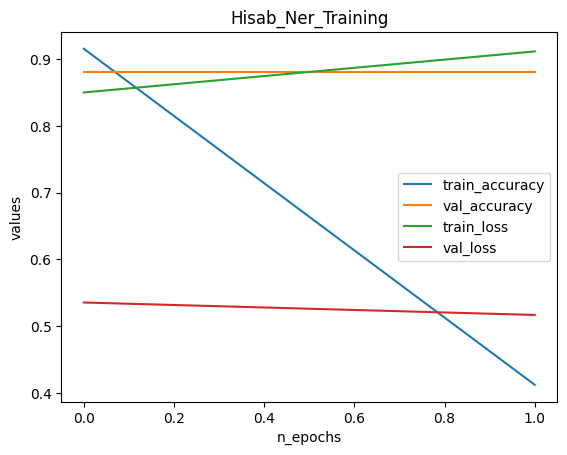

In [42]:
from matplotlib import pyplot as plt
plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.title('Hisab_Ner_Training')
plt.xlabel('n_epochs')
plt.ylabel('values')

plt.legend()
plt.savefig('hisab_ner.png')
plt.show

# Evaluate Model

In [ ]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')


evaluate(model, df_test)

Test Accuracy:  0.943


# Predict One Sentence

In [51]:
def align_word_ids(texts):

    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def predict(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # if use_cuda:
    #     model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    sentence = sentence.split(' ')
    ner_result = ''
    if len(sentence)==len(prediction_label):
        for idx in range(len(prediction_label)):
            # if prediction_label[idx] == 'U-PERSON':
            #     ner_result += sentence[idx] + ','
            if prediction_label[idx] == 'B-PERSON':
                ner_result += sentence[idx]
            elif prediction_label[idx] == 'I-PERSON':
                ner_result += ' ' + sentence[idx]
        print(ner_result+'\n')
    else:
        print('------------------------------------------------------------------------\n\nInput Text: {}'.format(sentence))
        print('Predicted labels: {}\n'.format(prediction_label))



# Infer on example sentence

In [52]:
sentence = 'আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম'

# Inference Result

In [53]:
model = torch.load('/content/drive/MyDrive/Hisab/hisab_ner.pth')
predict(model, sentence)